# Music Genre Classification
In this notebook is based on the basic concepts of neural networks and uses it to classify the music files in dataset. Majorly this notebook can be divided into 3 parts:

   1) Using ANN 

   2) Tackling overfitting with ANN

   3) Using CNN


Also to read the dataset I have used librosa library which only read files <1Mb and one file is greater than the size giving error due to which I have ignored it. The dataset contains the following genres, the keys being the prediction targets
    
    0: "disco",
    1: "metal",
    2: "reggae",
    3: "blues",
    4: "rock",
    5: "classical",
    6: "jazz",
    7: "hiphop",
    8: "country",
    9: "pop"


In [1]:
import os
import librosa
import math
import json 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset_path = r"../input/gtzan-dataset-music-genre-classification/Data/genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 3
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [3]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
             hop_length=512, num_segments=5):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK/num_segments) # ps = per segment
    expected_vects_ps = math.ceil(samples_ps/hop_length)
    
    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensuring not at root
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")
            
            # process files for specific genre
            for f in filenames:
                if(f==str("jazz.00054.wav")):
                    # As librosa only read files <1Mb
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=SAMPLE_RATE)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                    sr = sr,
                                                    n_fft = n_fft,
                                                    n_mfcc = n_mfcc,
                                                    hop_length = hop_length)

                        mfcc = mfcc.T

                        # store mfcc if it has expected length 
                        if len(mfcc)==expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print(f"{file_path}, segment: {s+1}")

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)
        

In [4]:

from IPython.display import clear_output

In [5]:
save_mfcc(dataset_path,json_path,num_segments=10)
# clear_output()

Processing: disco
../input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segment: 1
../input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segment: 2
../input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segment: 3
../input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segment: 4
../input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segment: 5
../input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segment: 6
../input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segment: 7
../input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segment: 8
../input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav, segment: 9
../input/gtzan-dataset-music-genre-cl

In [6]:
filepath = r"../input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.0000"

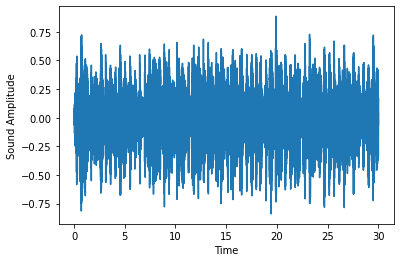

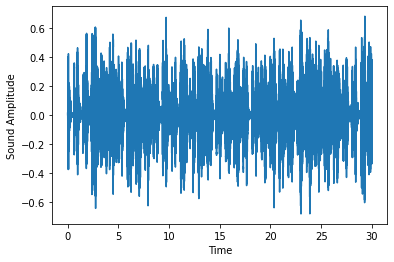

In [7]:
for i in range(2):
    audio, sfreq = librosa.load(filepath+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

# Classifier
This part uses the concepts of ANN with keras and sequential layers. I have also done splitting in the ratio 70:30

The model is Sequential and architecture only has Flatten and the Dense layers available in keras for the basic ANN representation. As it is naive model we can expect it to be overfit. Info on the layers can be found [here](https://machinelearningknowledge.ai/different-types-of-keras-layers-explained-for-beginners/)

In [8]:
import json
import numpy as np

In [9]:
# load data
def load_data(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)
    
    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])    
    
    return inputs,targets

In [10]:
inputs,targets = load_data(r"./data.json")

In [11]:
# splitting the data
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)

(6993, 13, 13) (6993,)


In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

In [13]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 169)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               87040     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 235,466
Trainable params: 235,466
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(lr=1e-4)

In [15]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [16]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)
clear_output()

In [17]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

<Figure size 1440x1080 with 0 Axes>

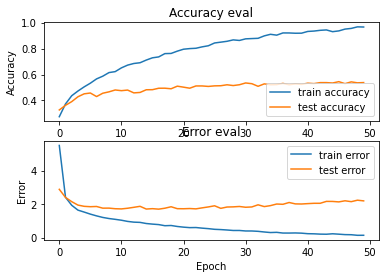

In [18]:
plot_history(hist)

In [19]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 2ms/step - loss: 2.1903 - accuracy: 0.5379
Test accuracy: 0.5378711819648743


# Overfitting
This part deals with the overfitting of the previous model. We can deal with it by majorly doing the following process.
- Making architecture less complicated 
- Using augmented data
- Early stopping of training
- Adding dropout layers
- Regularization / Standardization  

I have added the dropout layers and kernel_regularizers as compared to previous naive model giving the dropout probability as 30%
Kernel_regularizers is one of the 3 type of regularizer used to impose penalties. More info can be found [here](https://medium.com/@robertjohn_15390/regularization-in-tensorflow-using-keras-api-48aba746ae21)

In [20]:
import tensorflow.keras as keras

In [21]:
# Overfitting
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 169)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               87040     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [22]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)

clear_output()

<Figure size 1440x1080 with 0 Axes>

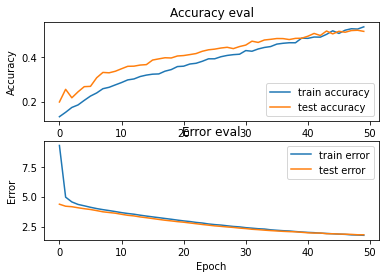

In [23]:
plot_history(hist)

In [24]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 2ms/step - loss: 1.8195 - accuracy: 0.5175
Test accuracy: 0.5175175070762634


We can see that the overfitting is greatly reduced but still we are not able to get a good accuracy. Now we will try doing it with Convolutional Neural Network (CNN)

# CNN
Using keras layers of Conv2D, MaxPool2D, BatchNormalization.

CNN layers takes input primarily in 3D shape, so we again have to prepare the dataset in the form and for that, I have used np.newaxis function which adds a column/layer in the data

In [25]:
def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"./data.json")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [26]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [27]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(13, 13, 1)


In [28]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 11, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 6, 64)          256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 32)          18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 32)          128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 32)         

In [29]:
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 40,
                 batch_size = 32)

Epoch 1/40
188/188 [==============================] - 5s 6ms/step - loss: 2.2240 - accuracy: 0.2236 - val_loss: 1.9370 - val_accuracy: 0.3416
Epoch 2/40
188/188 [==============================] - 1s 4ms/step - loss: 1.8774 - accuracy: 0.3389 - val_loss: 1.7494 - val_accuracy: 0.3716
Epoch 3/40
188/188 [==============================] - 1s 4ms/step - loss: 1.7677 - accuracy: 0.3773 - val_loss: 1.6711 - val_accuracy: 0.4003
Epoch 4/40
188/188 [==============================] - 1s 4ms/step - loss: 1.7205 - accuracy: 0.3915 - val_loss: 1.6250 - val_accuracy: 0.4270
Epoch 5/40
188/188 [==============================] - 1s 4ms/step - loss: 1.6483 - accuracy: 0.4313 - val_loss: 1.5930 - val_accuracy: 0.4263
Epoch 6/40
188/188 [==============================] - 1s 4ms/step - loss: 1.6416 - accuracy: 0.4146 - val_loss: 1.5530 - val_accuracy: 0.4436
Epoch 7/40
188/188 [==============================] - 1s 4ms/step - loss: 1.5825 - accuracy: 0.4238 - val_loss: 1.5482 - val_accuracy: 0.4423
Epoch 

<Figure size 1440x1080 with 0 Axes>

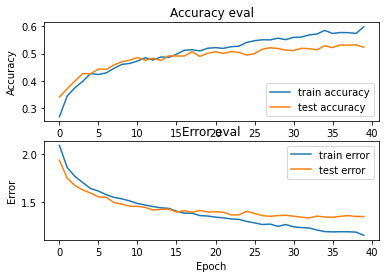

In [30]:
plot_history(hist)

In [31]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 [==============================] - 0s 2ms/step - loss: 1.3410 - accuracy: 0.5248
Test accuracy: 0.5248198509216309


In [34]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [35]:
predict(model, X_test[10], y_test[10])

Expected index: 5, Predicted index: [5]


As we can see the accuracy has improved but still the accuracy is not enough, in the future implementation of RNN model could be used with ensembling to get a push in accuracy.